In [1]:
import numpy as np
import numpy.linalg as la
import scipy.spatial.distance as dist
import random

In [2]:
class SVM:
    
    '''
    Класс, представляющий реализацию классификации данных методом опорных векторов.
    SVM - Support Vector Machine
    '''
    
    def __init__(self, kernel='linear', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iters=10000):
        
        '''
        Конструктор класса.
        Параметры:
        - kernel - ядро ('linear', 'poly' и 'rbf')
        - С - параметр регуляризации
        - degree - степень полиноминальной функции ядра 
        - gamma - используется в ядре 'rbf'
        - tol - для реализации алгоритма SMO
        - max_iters - максимальное количество итераций 
        '''
        
        # ядра
        Kernels = {
            'linear': lambda x, y: np.dot(x, y.T),
            'poly': lambda x, y: np.dot(x, y.T)**degree,
            'rbf': lambda x, y: np.exp(-self.gamma*dist.cdist(np.atleast_2d(x), np.atleast_2d(y))**2).flatten()
        }
        
        if kernel not in Kernels:
            raise ValueError(f"Недопустимое значение ядра {kernel}! Возможны значения: linear, poly, rbf.")
        
        self.kernel = Kernels[kernel]
        self.kernel_name = kernel # понадобиться позже
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.tol = tol
        self.max_iters = max_iters
        
        # для SMO
        self.b = 0
        self.K = 0
        self.alpha = 0
        
    # -----------------------------------------------------------------------------------------------------------------------
        
    def _input(self, x, y):
        
        '''
        Подпрограмма для обработки входных данных.
        Обрабатывает корректность входных данных, а на выходе преобразует их в numpy-массивы.
        Параметры:
        - x - набор данных объекта
        - y - массив меток
        '''
        
        # -> np.array
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        
        # если пустой, то выкинем исключение
        if not len(x):
            raise ValueError("Набор данных объекта не должен быть пустым!")
        
        # -> np.array
        if not isinstance(y, np.ndarray):
            y = np.array(y)
        
        # если пустой, то выкинем исключение
        if not len(y):
            raise ValueError("Массив меток не должен быть пустым!")
        
        # кол-во образцов 
        self.n_samples = x.shape[0]
        
        # кол-во характеристик
        self.n_features = x.shape[1]
        
        # кол-во классов
        self.n_classes = len(set(y))
        
        self.x = x
        self.y = y
        
    # -----------------------------------------------------------------------------------------------------------------------
    
    def _predict_row(self, x):
        
        '''
        Вспомогательная подпрограмма для алгоритма SMO.
        Вычисляем f(x).
        '''
        kernel_prod = self.kernel(self.x[self.sv_idx], x)
        return np.dot((self.alpha[self.sv_idx]*self.y[self.sv_idx]).T, kernel_prod.T) + self.b
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    def predict(self, x):
        
        '''
        Подпрограмма, которая предсказывает, к какому классу относятся элементы массива x.
        '''
        res = []
        for i in range(x.shape[0]):
            res.append(np.sign(self._predict_row(x[i, :])))
        
        return np.array(res)
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    def _err(self, index):
        
        '''
        Ошибка для экземпляра с индексом 'index'
        '''
        return self._predict_row(self.x[index]) - self.y[index]
        
    # -----------------------------------------------------------------------------------------------------------------------
    
    def _random_index(self, index):
        
        '''
        Подпрограмма, которая возвращает случайных индекс из диапазона
        [0, self.n_samples - 1], не равный индексу 'index'
        '''
        
        index_res = random.randint(0, self.n_samples - 1)
        while index_res == index:
            index_res = random.randint(0, self.n_samples - 1)
            
        return index_res
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    def _bounds(self, i, j):
        
        '''
        Подпрограмма, которая находит границы L и H для алгоритма SMO.
        Параметры:
        - i, j - индексы
        Возвращаемое значение:
        - L, H - границы
        '''
        
        if self.y[i] != self.y[j]:
            
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
            
        else:
            
            L = max(0, self.alpha[i] - self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] - self.alpha[j])
            
        return L, H
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    def _clip(self, L, H, alpha):
        
        '''
        Подпрограмма, которая устанавливаем значение параметра альфа
        в соответствии с системой.
        '''
        
        if alpha > H:
            alpha = H
        
        if alpha < L:
            alpha = L
            
        return alpha
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    def _compute_b(self, b1, b2, i, j):
        
        if 0 < self.alpha[i] < self.C:
            return b1
        if 0 < self.alpha[j] < self.C:
            return b2
        return (b1 + b2)/2
    
    # -----------------------------------------------------------------------------------------------------------------------

    def _train(self):
        
        '''
        Подпрограмма обучения на тренировочном наборе данных.
        Строится разделяющая гиперплоскость.
        Реализуется алгоритм SMO для решения задачи квадратичного программирования.
        '''
        
        iter_counter = 0
        while iter_counter < self.max_iters:
            
            num_changed_alphas = 0
                
            for i in range(self.n_samples):
                    
                # ошибка
                err_i = self._err(i)
                
                # условия ККТ
                if ((self.y[i]*err_i < -self.tol) and (self.alpha[i] < self.C)) or \
                   ((self.y[i]*err_i > self.tol) and (self.alpha[i] > 0)):
                
                    # находим случайный индекс
                    j = self._random_index(i)
                    
                    # ошибка
                    err_j = self._err(j)
                    
                    # сохраняем старые значения параметров
                    alpha_i_old = self.alpha[i]
                    alpha_j_old = self.alpha[j]
                    
                    # находим границы
                    L, H = self._bounds(i, j)
                    
                    # если равны, то след. итерация
                    if L == H:
                        continue 
                    
                    # считаем параметр в соответствии с формулой
                    eta = 2*self.K[i, j] - self.K[i, i] - self.K[j, j]
                    
                    # если 0, то след. итерация
                    if eta >= 0:
                        continue 
                        
                    # обновляем значения параметра альфа
                    self.alpha[j] -= self.y[j]*(err_i - err_j)/eta
                    self.alpha[j] = self._clip(L, H, self.alpha[j])
                    
                    if np.abs(self.alpha[j] - alpha_j_old) < self.tol:
                        continue
                    
                    self.alpha[i] += self.y[i]*self.y[j]*(alpha_j_old - self.alpha[j])
                    
                    # находим значения b
                    b1 = self.b - err_i - self.y[i]*(self.alpha[i] - alpha_i_old)*self.K[i, i] \
                                    - self.y[j]*(self.alpha[j] - alpha_j_old)*self.K[i, j]
                    
                    b2 = self.b - err_j - self.y[j]*(self.alpha[j] - alpha_j_old)*self.K[j, j] \
                                    - self.y[i]*(self.alpha[i] - alpha_i_old)*self.K[i, j]
                    
                    self.b = self._compute_b(b1, b2, i, j)
                    
                    num_changed_alphas += 1
                
            if num_changed_alphas == 0:
                break
                
            iter_counter += 1
        
        # сохраним индексы опорных векторов
        self.sv_idx = np.where(self.alpha > 0)[0]    
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    def fit(self, x, y):
        
        '''
        Подпрограмма классификации.
        Параметры:
        - x - набор данных объекта
        - y - массив меток
        '''
        
        # обработка входных данных
        self._input(x, y)
        
        # матрица скалярных произведений
        self.K = np.zeros((self.n_samples, self.n_samples))
        for index in range(self.n_samples):
            self.K[:, index] = self.kernel(self.x, self.x[index, :])
            
        # для SMO
        self.alpha = np.zeros(self.n_samples)
        
        # опорные вектора
        # suppert vectors indexes
        self.sv_idx = np.arange(0, self.n_samples)
        
        # возвращаем результат обучения
        return self._train()
    
    # -----------------------------------------------------------------------------------------------------------------------

# <center> ТЕСТИРОВАНИЕ БИНАРНОГО SVM

Для того, что судить о том, насколько хорошо показывает себя написанная версия SVM - будем сравнивать его результаты с SVM из библиотеки языка Python sklearn.

In [3]:
from sklearn.svm import SVC

## <center> Тест 1. <br> Ирисы Фишера.

In [4]:
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = datasets.load_iris()

X = data.data
Y = data.target
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


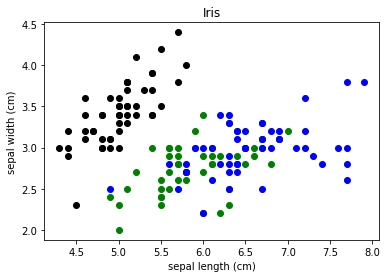

In [5]:
import matplotlib.pyplot as plt

colors = {0:'k', 1:'g', 2:'b'}
fig, ax = plt.subplots()
for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1],color=colors[Y[i]])
# set a title and labels
ax.set_title('Iris')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')

plt.show()

Приведем при помощи преобразований данный датасет к бинарному (чтобы метки классов были -1 и 1 соответственно).
Таким образом, класс 0 (Setosa) превратится в -1, классы 1 (Versicolor) и 2 (Virginica) - в +1. 

In [6]:
# [0, 1, 2] -> [False, True, True] -> [0, 1, 1] -> [0, 2, 2] -> [-1, 1, 1]
Y = (Y > 0).astype(int)*2 - 1 
print(Y)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

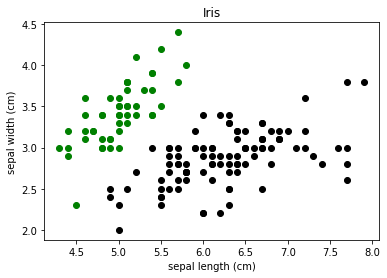

In [8]:
colors = {+1:'k', -1:'g'}
fig, ax = plt.subplots()
for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1],color=colors[Y[i]])
# set a title and labels
ax.set_title('Iris')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')

plt.show()

## <center> Наша SVM.

Параметры по умолчанию. 

In [9]:
%%time
cls = SVM() 
cls.fit(X_train, Y_train)

Wall time: 32.9 ms


In [10]:
print(f'Результаты классификации нашей SVM: {cls.predict(X_test)}')
print(f'Реальный метки классов: {Y_test}')

Результаты классификации нашей SVM: [ 1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.
  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.
  1.  1.  1.  1. -1.  1.]
Реальный метки классов: [ 1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1  1 -1  1  1  1 -1 -1  1  1 -1
  1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1  1 -1  1  1  1  1
  1  1 -1  1  1 -1  1  1  1  1 -1  1]


In [11]:
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 100.000%


Изменим параметры. Ядро пусть будет 'poly', C = 0.1, max_iters = 1000.

In [12]:
%%time
cls = SVM(kernel='poly', C=10.0, tol = 10**-100, max_iters=1000) 
cls.fit(X_train, Y_train)

Wall time: 34.9 ms


In [13]:
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 100.000%


Изменим параметры. Ядро пусть будет 'rbf'.

In [14]:
%%time
cls = SVM(kernel='rbf')
cls.fit(X_train, Y_train)

Wall time: 263 ms


In [15]:
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 100.000%


## <center> Sklearn SVM.

Параметры по умолчанию.

In [16]:
%%time
cls = SVC(kernel='linear', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iter=10000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 100.000%
Wall time: 4.96 ms


Изменим параметры. Ядро пусть будет 'poly', C = 0.1, max_iters = 1000.

In [17]:
%%time
cls = SVC(kernel='poly', C=0.1, degree=3, gamma=0.1, tol=10**-3, max_iter=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 100.000%
Wall time: 998 µs


 Изменим параметры. Ядро пусть будет 'rbf'.

In [18]:
%%time
cls = SVC(kernel='rbf', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iter=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 100.000%
Wall time: 1.98 ms


# <center> Тест 2. <br> Breast Cancer (рак молочной железы).

In [19]:
data = datasets.load_breast_cancer()

X = data.data
Y = data.target
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

In [20]:
Y = np.array([y if y == 1 else -1 for y in Y])
print(Y)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1
 -1 -1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1 -1 -1
  1  1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1 -1
  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1
 -1  1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1
  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1 -1  1  1 -1 -1  1 -1
  1  1  1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1 -1

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

Параметры по умолчанию. 

In [22]:
%%time
cls = SVM() 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 88.596%
Wall time: 37.9 s


In [23]:
%%time
cls = SVC(kernel='linear', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iter=10000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 90.789%
Wall time: 19.9 ms


C:\Users\Emil\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Изменим параметры. Ядро пусть будет 'poly', C = 10.0, tol=10^(-100), max_iters = 1000.

In [24]:
%%time
cls = SVM(kernel='poly', C=10.0, tol=10**-100, max_iters=10000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 89.474%
Wall time: 59.4 s


In [25]:
%%time
cls = SVC(kernel='poly', C=10.0, max_iter=10000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 92.105%
Wall time: 4.99 ms


 Изменим параметры. Ядро пусть будет 'rbf', gamma = 0.007, max_iters = 2000.

In [26]:
%%time
cls = SVM(kernel='rbf', gamma=0.007, max_iters=2000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 81.579%
Wall time: 1min 49s


In [27]:
%%time
cls = SVC(kernel='rbf', gamma=0.007) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 60.088%
Wall time: 18 ms


# <center> SVM для мультиклассификации.

In [28]:
class SVM_multi(SVM):
    
    '''
    Класс, представляющий мультиклассификацию методом опорных векторов.
    Реализуется метод Один-Против-Всех (OVA - One-Vs-All).
    SVM - Support Vector Machine.
    '''
    
    def __init_(self, kernel='linear', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iters=10000):
        
        '''
        Конструктор класса.
        Параметры:
        - kernel - ядро ('linear', 'poly' и 'rbf')
        - С - параметр регуляризации
        - degree - степень полиноминальной функции ядра 
        - gamma - используется в ядре 'rbf'
        - tol - для реализации алгоритма SMO
        - max_iters - максимальное количество итераций 
        '''
        super.__init__(kernel, C, degree, gamma, tol, max_iters)
        
    # -----------------------------------------------------------------------------------------------------------------------
        
    def fit(self, x, y):
        
        '''
        Подпрограмма обучения на тренировочных данныых.
        Параметры:
        - x - обучающая выборка
        - y - массив меток
        '''
        
        self._input(x, y)
        
        # отранжируем по частоте встречаемости класса 
        frequencies = dict()
        labels = list(set(y))
        for label in labels:
            frequencies[label] = list(y).count(label)        
        self.frequencies = list(sorted(frequencies.items(), reverse=True))

        # массив SVM
        self.machines = []
        
        # список корректных меток
        self.true_labels = []
        
        # релизауем мультиклассификацию One-Vs-All
        for freq in self.frequencies:
            
            self.true_labels.append(freq[0])
            
            X = x.copy()
            Y = y.copy()
            
            Y = np.array([+1 if y == freq[0] else -1 for y in Y])

            self.machines.append(
                SVM(kernel=self.kernel_name, C=self.C, degree=self.degree, 
                    gamma=self.gamma, tol=self.tol, max_iters=self.max_iters)
            )
            self.machines[-1].fit(X, Y)
                        
        # массив вероятности встречаемости класса
        self.p = np.array([list(y).count(label) / len(y) for label in self.true_labels])

    # -----------------------------------------------------------------------------------------------------------------------
    
    def predictOne(self, x_j):
        
        keys = self.true_labels
        votes = {}
        for key in keys: votes[key] = 0
        
        # цикл по всем построенным SVM
        for k, machine in enumerate(self.machines):
            
            probs = np.sign(machine._predict_row(x_j)) 
            
            # за какой класс какая SVM "голосует"
            votes[keys[k]] += 1 if probs == 1 else 0
            
        return max(votes, key=votes.get)

    
    def predict(self, X):
        
        '''
        Подпрограмма, которая классифицирует обученной моделью выборку x.
        '''
        
        # результирующий массив меток
        labels = [] 
        
        # цикл по всем объектам
        for j in range(X.shape[0]):
            
            labels.append(self.predictOne(X[j, :]))

        return np.array(labels)
    
    # -----------------------------------------------------------------------------------------------------------------------
    
    #def predict(self, X):
    #    
    #    '''
    #    Подпрограмма, которая классифицирует обученной моделью выборку x.
    #    '''
    #    
    #    # результирующий массив меток
    #    labels = [] 
    #    
    #    # цикл по всей выборке
    #    for j in range(X.shape[0]):
    #        
    #        ind = -1
    #        
    #        # цикл по всем построенным SVM
    #        for i, machine in enumerate(self.machines):
    #            
    #            # если 1, то нашли нужный класс
    #            if np.sign(machine._predict_row(X[j, :])) == 1:
    #                ind = i
    #                break
    #        
    #        # ветка с -1 на случай, если объект не был отнесен ни к какому классу 
    #        if ind == -1:
    #            labels.append(np.random.choice(self.true_labels, p=self.p)) 
    #        else:
    #            labels.append(self.true_labels[ind])
    #    
    #    return labels

## <center> Тест 1. <br> Ирисы Фишера.

In [29]:
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

data = datasets.load_iris()

X = data.data
Y = data.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

## <center> Параметры по умолчанию. 

In [30]:
%%time
cls = SVM_multi() 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 56.667%
Wall time: 29.6 s


In [31]:
%%time
cls = SVC(kernel='linear', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iter=10000, decision_function_shape='ovr') 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 93.333%
Wall time: 2 ms


## <center> Изменим параметры.

In [32]:
%%time
cls = SVM_multi(kernel='poly', C=1.0, tol=10**-100, max_iters=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 48.333%
Wall time: 3.89 s


In [33]:
%%time
cls = SVC(kernel='poly', C=1.0, degree=3, gamma=0.1, tol=10**-100, max_iter=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 91.667%
Wall time: 1.97 ms


C:\Users\Emil\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


## <center> Изменим параметры.

In [34]:
%%time
cls = SVM_multi(kernel='rbf', C=1.0, gamma = 0.1, tol=10**-7, max_iters=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 80.000%
Wall time: 9.87 s


In [35]:
%%time
cls = SVC(kernel='rbf', C=1.0, gamma=0.1, tol=10**-7, max_iter=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 93.333%
Wall time: 1.99 ms


## <center> Тест 2. <center> Нефтяной датасет.

In [36]:
def CreateData(path):
    
    '''
    Функция преобразует данные из Excel в набор данных X и Y.
    Для X[i] берем данные из первых двух столбцов ('Liquid' и 'Gas'), для Y[i] берем данные из столбца с 
    заголовком 'Label'.
    '''
    
    data = pd.read_excel(path)
    data = data.to_dict()
    keys = list(data.keys())

    x = []
    y = []
    
    for i in range(len(data[keys[0]])):
        x.append([data[keys[0]][i], data[keys[1]][i]])
        y.append(data['Label'][i])
    
    return np.array(x), np.array(y)

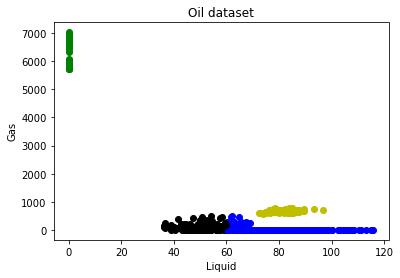

In [38]:
import pandas as pd

# блок подготовки данных
path = 'D:\\MPEI\\5\\Программная инженерия 2\\Курсовой проект\\KursProject\\DataSets\\'
X, Y = CreateData(path + 'dataset1.xlsx')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

data = pd.read_excel(path + 'dataset1.xlsx')
colors = {21:'k', 13:'g', 31:'b', 32:'y'}
fig, ax = plt.subplots()

for i in range(len(data['Liquid'])):
    ax.scatter(data['Liquid'][i], data['Gas'][i],color=colors[data['Label'][i]])

ax.set_title('Oil dataset')
ax.set_xlabel('Liquid')
ax.set_ylabel('Gas')
plt.show()

## <center> Параметры по умолчанию.

In [39]:
%%time
cls = SVM_multi() 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 10.088%
Wall time: 13.7 s


In [40]:
%%time
cls = SVC(kernel='linear', C=1.0, degree=3, gamma=0.1, tol=10**-3, max_iter=10000, decision_function_shape='ovr') 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 99.561%
Wall time: 2.91 ms


## <center> Изменим параметры.

In [41]:
%%time
cls = SVM_multi(kernel='poly', C=10.0, degree=5, tol=10**-99, max_iters=1777) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 60.088%
Wall time: 1min 24s


In [42]:
%%time
cls = SVC(kernel='poly', C=10.0, degree=5, gamma=0.1, tol=10**-99, max_iter=1777, decision_function_shape='ovr') 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 99.123%
Wall time: 2.62 ms


C:\Users\Emil\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1777).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


## <center> Изменим параметры. 

In [43]:
%%time
cls = SVM_multi(kernel='rbf', C=0.1, gamma=0.006, tol=10**-9, max_iters=1000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 66.667%
Wall time: 1min 54s


In [44]:
%%time
cls = SVC(kernel='rbf', C=0.1, gamma=0.006, tol=10**-9, max_iter=1000, decision_function_shape='ovr') 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 76.754%
Wall time: 14 ms


C:\Users\Emil\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


# <center> Ну и еще раз изменим.

In [45]:
%%time
cls = SVM_multi(kernel='rbf', C=10.1, gamma=0.006, tol=10**-9, max_iters=3000) 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 89.474%
Wall time: 6min 3s


In [47]:
%%time
cls = SVC(kernel='rbf', C=10.1, gamma=0.006, tol=10**-9, max_iter=3000, decision_function_shape='ovr') 
cls.fit(X_train, Y_train)
print(f'Точность классификации равняется: {accuracy_score(Y_test, cls.predict(X_test))*100:.3f}%')

Точность классификации равняется: 94.737%
Wall time: 16 ms


C:\Users\Emil\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
